# Spectrum CNN

Automatic modulation recognition with CNN using spectrogram data based on technique from Zeng et al's paper "Spectrum Analysis and Convolutiopnal Neural Netowrk for Automatic Modulation Recognition" published in IEEE Wireless Communications Letters, Vol 8, No 3, of June 2019.

This example deviates from Zeng et al's in tje following ways:

- Spectrogram data (CNN input) is provided as a 2D (time and freqnency) array of intensity values as apposed to a 3D (time, frequency, and three color channels) array. This allows Conv2D layers to be used vs Conv3D. This change reduces the number of learned parameters from 199k to 172k.


- The dataset combines spectrograms from multiple SNRs (0 to 18 dB) vs only using a single SNR per model. This is inteded to make the trained model more robust to noise by 1) providing more training data, and 2) providing a wider variety of data due to various ammounts of noise present.

In [56]:
import sys
sys.path.append("../modules")

import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation


import utilities as ut
import preprocess
import visualize as viz

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

The following cell can be run to reload the iq_utils modlue after editing during notebook testing

In [74]:
from importlib import reload
reload(ut)
reload(preprocess)
reload(viz)

<module 'visualize' from '../modules/visualize.py'>

# Get dataset

## Option 1: Load dataset

In [19]:
spec_dict = ut.from_pickle('../processed_data/spectrogram_dict_MPh')

## Option 2: Generate Dataset

In [3]:
filename = "../datasets/RML2016_10a_dict.pkl"
raw_data = ut.load_dataset(filename)
# _, snrs = ut.get_mods_and_snrs(raw_data)

snrs = [10, 12, 14, 16, 18]

data_dict = preprocess.select_SNRs(raw_data, snrs)

n_ex = data_dict['x'].shape[0]

In [4]:
data_dict['x'].shape

(55000, 128)

In [5]:
print('There are {} examples in dataset.'.format(data_dict['x'].shape[0]))
print('Each example is a complex vector of length of {}.'.format(data_dict['x'].shape[1]))
print('There were {} SNRs used.'.format(len(snrs)))

There are 55000 examples in dataset.
Each example is a complex vector of length of 128.
There were 5 SNRs used.


In [66]:
spec_dict = preprocess.process_spec(data_dict, nperseg=29, noverlap=28, n_ex=None, nfft=100, 
                            inph=0, quad=0, mag=1, ph=0, ph_unwrap=1)

In [67]:
print('There are {} examples in dataset.'.format(spec_dict['x_s'].shape[0]))
print('Spectrograms are of shape: ', spec_dict['x_s'].shape[1:])

There are 55000 examples in dataset.
Spectrograms are of shape:  (100, 100, 2)


## Train/test split

In [68]:
X_train, y_train, X_test, y_test = preprocess.process_data(spec_dict, test_split=0.0, blur=False)

In [69]:
print('There are {} samples in the trianing set and {} in the testing set'.format(X_train.shape[0], X_train.shape[0]))

There are 55000 samples in the trianing set and 55000 in the testing set


## Build model

In [70]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=X_train.shape[1:], padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(12, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(8, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(11, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [71]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 100, 100, 64)      1216      
_________________________________________________________________
batch_normalization_12 (Batc (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 50, 50, 32)        18464     
_________________________________________________________________
batch_normalization_13 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 32)       

## Train model
Zeng et al does not discuss the size of batches used or if overfitting occured

In [72]:
history_MPun = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_split=0.1, verbose=1)

Train on 49500 samples, validate on 5500 samples
Epoch 1/50
49500/49500 [==============================] - 32s 650us/sample - loss: 1.0680 - accuracy: 0.5472 - val_loss: 5.1105 - val_accuracy: 0.1325
Epoch 2/50
49500/49500 [==============================] - 36s 734us/sample - loss: 0.6622 - accuracy: 0.6912 - val_loss: 1.8961 - val_accuracy: 0.4065
Epoch 3/50
49500/49500 [==============================] - 40s 817us/sample - loss: 0.5680 - accuracy: 0.7228 - val_loss: 0.9396 - val_accuracy: 0.6062
Epoch 4/50
49500/49500 [==============================] - 41s 818us/sample - loss: 0.5325 - accuracy: 0.7357 - val_loss: 0.6028 - val_accuracy: 0.7313
Epoch 5/50
49500/49500 [==============================] - 43s 871us/sample - loss: 0.5113 - accuracy: 0.7460 - val_loss: 1.0330 - val_accuracy: 0.6402
Epoch 6/50
49500/49500 [==============================] - 43s 874us/sample - loss: 0.5005 - accuracy: 0.7504 - val_loss: 0.6166 - val_accuracy: 0.7327
Epoch 7/50
49500/49500 [=====================

## View training stats

Plot description: 
Magnitude and phase spectrograms, trained for 50 epochs. 
SNRs of 10 to 18 were used.

final accuracy:			0.869939386844635
final validation accuracy:	0.836545467376709


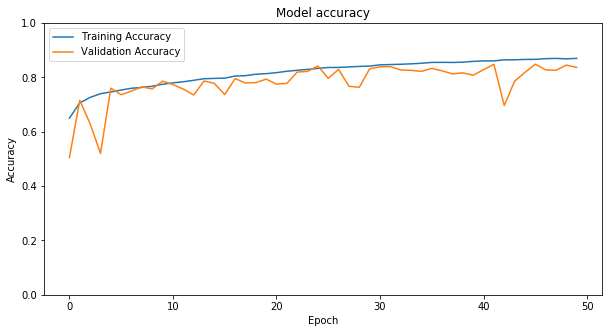

In [75]:
desc = f"""
Magnitude and phase spectrograms, trained for {len(history_MP.history['accuracy'])} epochs. 
SNRs of 10 to 18 were used.
"""

viz.plot_history(history_MP, desc)

Plot description: 
Magnitude and phase (unwrapped) spectrograms, trained for 50 epochs. 
SNRs of 10 to 18 were used.

final accuracy:			0.8505252599716187
final validation accuracy:	0.8049091100692749


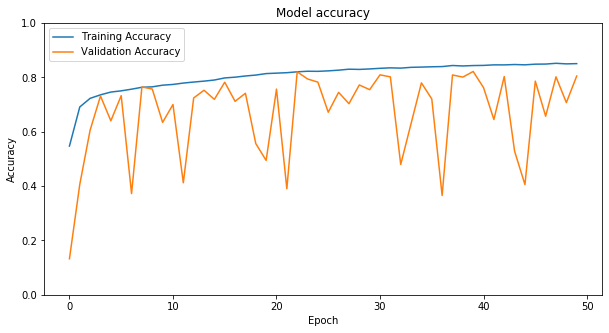

In [76]:
desc = f"""
Magnitude and phase (unwrapped) spectrograms, trained for {len(history_MP.history['accuracy'])} epochs. 
SNRs of 10 to 18 were used.
"""

viz.plot_history(history_MPun, desc)

Plot description: 
In-phase and quadrature spectrograms trained for 50 epochs.
SNRs of 10 to 18 were used.



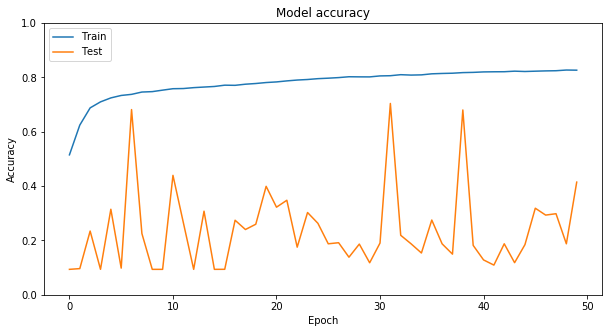

final accuracy:			0.826424241065979
final validation accuracy:	0.4145454466342926


In [65]:
desc = f"""
In-phase and quadrature spectrograms trained for {len(history_IQ.history['accuracy'])} epochs.
SNRs of 10 to 18 were used.
"""

viz.plot_historyory(history_IQ, desc)

## Evaluate model
TODO: this uses the training data as no seperate test data was set aside. There was discussion online about this, need to look into if further.

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0, batch_size=128)
print("Loss:\t\t{}\nAccuracy:\t{}".format(loss, accuracy))

## Save model

In [25]:
model.save('../models/cSCNNmp_10-18_50e.model')

INFO:tensorflow:Assets written to: ../models/cSCNNmp_10-18_50e.model/assets


## Load model

In [30]:
model = tf.keras.models.load_model('../models/cSCNNmp_10_18.model')

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 64)      1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)       